# **Задание 6. Тексты писателей.**

**Условие задачи**



В этой задаче вам нужно по фрагменту текста научиться предсказывать писателя, который этот текст написал. Среди писателей — Федор Достоевский, Борис Акунин, Кир Булычев, Антон Чехов, Николай Гоголь, Стивен Кинг, Терри Пратчетт и Эрих Мария
Ремарк. Все тексты на русском языке.


  


**Входные данные**


Тренировочная выборка train.csv представляет собой csv таблицу с тремя столбцами:
• "id": уникальный id текста
• "text": фрагмент текста произведения
• "author": автор текста

Тестовая выборка test.csv представляет собой csv таблицу с двумя столбцами столбцами: "id"и "text". Ваша задача — для каждого текста из тестовой выборки предсказать автора этого текста.

Данные и демоверсия находятся по [ссылке.](https://drive.google.com/drive/folders/1FGAHgURWjH0mCxnneX9Ps19b606_pJpu?usp=sharing)

Соревнование на [kaggle.](https://www.kaggle.com/competitions/task-6-demo/overview)

In [1]:
import os

import numpy as np
import tensorflow as tf
from sklearn.datasets import load_files



Проверяем, есть ли доступ к GPU.

In [2]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [91]:
DEVICE

device(type='cuda')

In [59]:
import numpy as np
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [ ]:
train

,id,text,author
0,171,Но материал-то остался. И довольно любопытный....,3
1,430,Вдруг Алешу осенило. Антония Николаевна расска...,3
2,116,"Проходит год или, может, полтора, родители её ...",3
3,231,"И встали у меня мозги на место. Дошло, что ник...",3
4,1716,-Не будьте так язвительны. Молодежи свойственн...,4
...,...,...,...
1468,1070,-Позволь и мне сесть возле тебя!- сказал кузне...,2
1469,971,"-А не жарко ли будет? Впрочем, изволь, папочка...",0
1470,1457,"Даже в Плоском мире, с его крошечным солнцем, ...",5
1471,1558,"Когда раскаты грома стихли вдали, Смерть медле...",5


In [ ]:
ids=test['id']
train=train.drop(columns=['id'])
test=test.drop(columns=['id'])

В стобце author фамилии заменены на коды. Соответствие между ними можно представлено ниже.

Chehov - 0

King - 1

Gogol - 2

Akunin - 3

Remark - 4

Pratchett - 5

Bulychev - 6

Dostoevsky - 7

In [ ]:
classes=train['author'].unique()
classes

array([3, 4, 0, 6, 5, 1, 2, 7])

Посмотрим на распределение данных по классам.

In [ ]:
sizes=[0 for i in range(len(classes))]
for i in range(len(classes)):
  sizes[i]=len(train[train['author']==classes[i]])

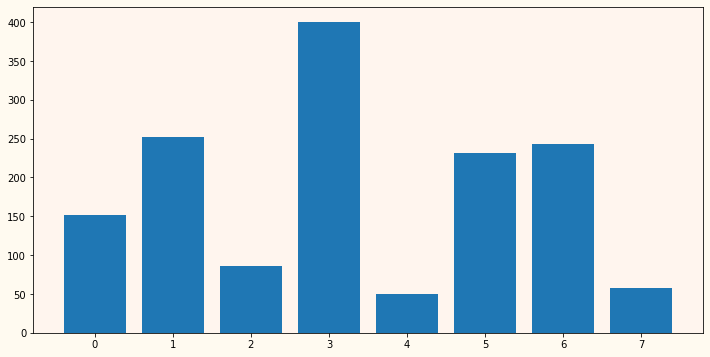

In [ ]:
import matplotlib.pyplot as plt

x = classes
y = sizes

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    
fig.set_figheight(6)  

plt.show()

Распределение очень неравномерное, что может сказаться на полученнном результате. 

Большинство алгоритмов балансировки данных проводят ещё и аугментацию и рассчитаны на работу только с численными данными. Поэтому представленный ниже способ выровнять количетсво данных по классам совсем "кустарный".

In [ ]:
train1=train.copy()

In [ ]:
train1=train1.append(train[train['author']==0])
train1=train1.append(train[train['author']==0])

train1=train1.append(train[train['author']==1])

train1=train1.append(train[train['author']==2])
train1=train1.append(train[train['author']==2])
train1=train1.append(train[train['author']==2])
train1=train1.append(train[train['author']==2])

train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])
train1=train1.append(train[train['author']==4])

train1=train1.append(train[train['author']==5])

train1=train1.append(train[train['author']==6])

train1=train1.append(train[train['author']==7])
train1=train1.append(train[train['author']==7])
train1=train1.append(train[train['author']==7])
train1=train1.append(train[train['author']==7])
train1=train1.append(train[train['author']==7])
train1=train1.append(train[train['author']==7])

In [ ]:
sizes=[0 for i in range(len(classes))]
for i in range(len(classes)):
  sizes[i]=len(train1[train1['author']==classes[i]])

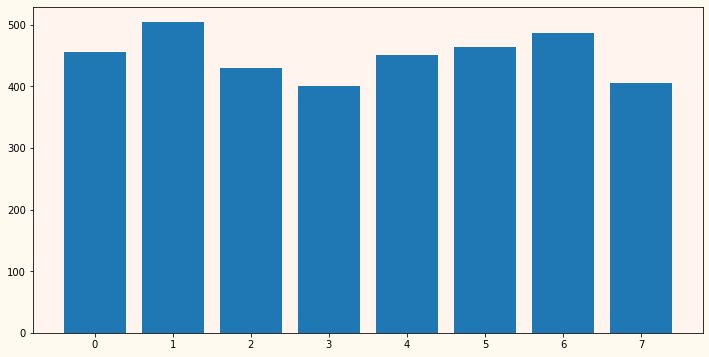

In [ ]:
x = classes
y = sizes

fig, ax = plt.subplots()

ax.bar(x, y)

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    
fig.set_figheight(6)  

plt.show()

In [ ]:
train=train1

Разделяем данные на те, которые будут использоваться для обучения и те, на которых будем тестировать.

In [ ]:
from sklearn.model_selection import train_test_split
X=train.drop(columns=['author'])
y=pd.DataFrame(train['author'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# **Решение на основе выделения слов признаков в тексте**

На основе имеющегося текста создаём вектор признаков, свидетельствующих о наличии/отсутствии определённых слов.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(2,5), stop_words=[],analyzer='word', max_features = 10000)

X_train_vector = vectorizer.fit_transform(X_train['text']).toarray()
X_test_vector = vectorizer.transform(X_test['text']).toarray()
X_test_total_vector = vectorizer.transform(test['text']).toarray()

Обучаем модель классифицировать текст по выделенным векторам признаков.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

rs = 42

clf = RandomForestClassifier(random_state=rs, n_jobs =-1)
clf.fit(X=X_train_vector, y=y_train)

<ipython-input-14-af0cccc64f77>:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X=X_train_vector, y=y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

Проверяем точность на данных, которые мы оставили для тестирования.

In [ ]:
y_pred=clf.predict(X_test_vector)

In [ ]:
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)

0.4479638009049774

In [ ]:
result=clf.predict(X_test_total_vector)

In [ ]:
from google.colab import files

ans = pd.concat([ids, pd.DataFrame(result)], axis= 1 )
t=ans.to_csv('prediction.csv', header=['id', 'author'], index=False)
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Решение на основе модели классификации текстов из autokeras**

Заново разделяем данные на test и train.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train,train, test_size=0.15)

In [ ]:
X_test

,id,text,author
998,998,"Медведенко. Да. Играть будет Заречная, а пьеса...",0
980,980,"Кузнец и руки опустил.\nТрудно рассказать, что...",0
1670,1670,Но их теории также далеки от истины.\nАрхиепис...,5
534,534,-Одиссей поручил Афине добыть для него оружие ...,3
1447,1447,"-А это поможет?\n-Кто-то считает, что так буде...",5
...,...,...,...
1289,1289,"Кевин нажал на кнопку.\nВспышка, питание на ко...",1
1474,1474,"Они живут… в общем-то, они живут где попало, н...",5
501,501,Второй этап путешествия тоже прошел без сучка ...,3
5,5,"-Ну что, как ты думаешь?\n-Да хорошо-то, хорош...",7


In [ ]:
print(sum(y_train))

12500


Устанавливаем библиотеку autokeras.

In [ ]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 466.8/466.8 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.2 MB/s eta 0:00:00


In [ ]:
import autokeras as ak

При инициализации классификатору передаётся параметр max_trial, равный количеству различных моделей, которые будут обучены, после чего из них автоматически будет выбрана та, которая даст более высокую точность.

In [ ]:
clf = ak.TextClassifier(num_classes=len(classes),
    overwrite=True, max_trials=1)  
clf.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=10)
predicted_y = clf.predict(X_test.to_numpy())

Trial 4 Complete [00h 00m 01s]

Best val_loss So Far: 1.0199238061904907
Total elapsed time: 00h 41m 15s
Epoch 1/10
40/40 [==============================] - 6s 105ms/step - loss: 1.9376 - accuracy: 0.2580
Epoch 2/10
40/40 [==============================] - 0s 12ms/step - loss: 1.8862 - accuracy: 0.2684
Epoch 3/10
40/40 [==============================] - 0s 10ms/step - loss: 1.8856 - accuracy: 0.2676
Epoch 4/10
40/40 [==============================] - 0s 10ms/step - loss: 1.8331 - accuracy: 0.2867
Epoch 5/10
40/40 [==============================] - 0s 9ms/step - loss: 1.6686 - accuracy: 0.3698
Epoch 6/10
40/40 [==============================] - 0s 9ms/step - loss: 1.3328 - accuracy: 0.5335
Epoch 7/10
40/40 [==============================] - 0s 9ms/step - loss: 1.0273 - accuracy: 0.6526
Epoch 8/10
40/40 [==============================] - 0s 10ms/step - loss: 0.7664 - accuracy: 0.7492
Epoch 9/10
40/40 [==============================] - 0s 9ms/step - loss: 0.5517 - accuracy: 0.8291
Epoch 1

7/7 [==============================] - 0s 8ms/step


In [ ]:
import sklearn
sklearn.metrics.accuracy_score(y_test, y_pred)

0.4479638009049774

In [ ]:
result=clf.predict(test['text'].to_numpy())

9/9 [==============================] - 0s 5ms/step


In [ ]:
from google.colab import files

ans = pd.concat([ids, pd.DataFrame(result)], axis= 1 )
t=ans.to_csv('prediction.csv', header=['id', 'author'], index=False)
files.download('prediction.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Основным достоинством autokeras является высокий уровень абстрации, что бозволяетдостаточно быстро написать решение поставленной задачи в условиях ограниченного на олимпиаде времени.

Также есть другие модели классификации текстов, где уровень абстакции гораздо ниже:



*   [Классификация средствами pytorch](https://colab.research.google.com/github/pytorch/text/blob/gh-pages/main/_downloads/764dcd36c4948c7e9a28df09d761099d/sst2_classification_non_distributed.ipynb#scrollTo=d5bQ1Q-iEPzo)
*  [ Использование моделей трансформеров](https://habr.com/ru/post/655517/)



# **Использование Моделей-трансформеров**

In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 23.8 MB/s eta 0:00:00


In [8]:
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

import torch
import transformers
import torch.nn as nn
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

tqdm.pandas()

Загружаем модель с предобученными весами

In [13]:
bert = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
train

,id,text,author
0,171,Но материал-то остался. И довольно любопытный....,3
1,430,Вдруг Алешу осенило. Антония Николаевна расска...,3
2,116,"Проходит год или, может, полтора, родители её ...",3
3,231,"И встали у меня мозги на место. Дошло, что ник...",3
4,1716,-Не будьте так язвительны. Молодежи свойственн...,4
...,...,...,...
1468,1070,-Позволь и мне сесть возле тебя!- сказал кузне...,2
1469,971,"-А не жарко ли будет? Впрочем, изволь, папочка...",0
1470,1457,"Даже в Плоском мире, с его крошечным солнцем, ...",5
1471,1558,"Когда раскаты грома стихли вдали, Смерть медле...",5


Разбиваем данные на test, valid и train

In [61]:
from sklearn.model_selection import train_test_split
X=train.drop(columns=['author'])
y=pd.DataFrame(train['author'])
train, val_test, y_train, y_test = train_test_split(train, train, test_size=0.3)
val, test1, Tmp1, tmp1=train_test_split(val_test, val_test, test_size=0.5)

In [62]:
train_text = train['text'].astype('str')
train_labels = train['author']
val_text = val['text'].astype('str')
val_labels = val['author']
test_text = test1['text'].astype('str')
test_labels = test1['author']

In [40]:
test_labels

805     3
348     2
1245    3
724     3
1209    1
       ..
1048    2
758     5
212     6
1237    0
1455    3
Name: author, Length: 155, dtype: int64

Модель обрабатывает текст частями, поэтому важно определить количество слов с определённой длиной

<Axes: >

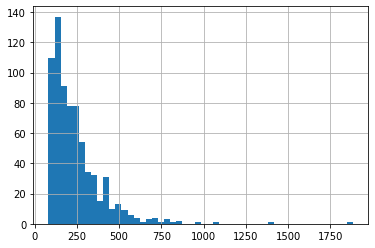

In [23]:
seq_len = [len(str(i).split()) for i in train_text]
pd.Series(seq_len).hist(bins = 50)

In [24]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.values,
    max_length = 200,
    padding = 'max_length',
    truncation = True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.values,
    max_length = 200,
    padding = 'max_length',
    truncation = True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.values,
    max_length = 200,
    padding = 'max_length',
    truncation = True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.values)

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.values)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.values)
batch_size = 8


train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

val_data =  TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size = batch_size)

Добавляем в модель слои для классификации

In [69]:
for param in bert.parameters():
    param.requires_grad = False
classes= len(train['author'].unique())
class BERT_Arch(nn.Module):
    
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,classes)
        self.softmax = nn.LogSoftmax(dim = 1)
    
    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask = mask, return_dict = False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [70]:
model = BERT_Arch(bert)

model = model.to(DEVICE)
from transformers import AdamW

optimizer = AdamW(model.parameters(),
               lr= 1e-3)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [74]:
cross_entropy = nn.CrossEntropyLoss()


Функции для обучения и валидации

In [75]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    
    for step, batch in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        batch = [r.to(DEVICE) for r in batch]
        sent_id,mask,labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)
        
    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    
    return avg_loss, total_preds

In [79]:
def evaluate():
    model.eval()
    total_loss, total_accuracy = 0,0
    total_preds = []

    for step, batch in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
        batch = [t.to(DEVICE) for t in batch]
        sent_id, mask, labels = batch
        
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis = 0)
    return avg_loss, total_preds


Обучаем модель

In [93]:
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
epochs=10
for epoch in range(epochs):
    print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
    
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    
   
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining loss: {train_loss:.3f}')
    print(f'Validation loss: {valid_loss:.3f}')



 Epoch1 / 10


100%|██████████| 20/20 [00:02<00:00,  9.78it/s]



Training loss: 1.900
Validation loss: 1.920

 Epoch2 / 10


100%|██████████| 20/20 [00:01<00:00, 10.22it/s]



Training loss: 1.886
Validation loss: 1.876

 Epoch3 / 10


100%|██████████| 20/20 [00:01<00:00, 10.59it/s]



Training loss: 1.883
Validation loss: 1.874

 Epoch4 / 10


100%|██████████| 20/20 [00:01<00:00, 10.68it/s]



Training loss: 1.897
Validation loss: 1.882

 Epoch5 / 10


100%|██████████| 20/20 [00:01<00:00, 10.66it/s]



Training loss: 1.908
Validation loss: 1.889

 Epoch6 / 10


100%|██████████| 20/20 [00:01<00:00, 10.48it/s]



Training loss: 1.884
Validation loss: 1.870

 Epoch7 / 10


100%|██████████| 20/20 [00:01<00:00, 10.37it/s]



Training loss: 1.886
Validation loss: 1.879

 Epoch8 / 10


100%|██████████| 20/20 [00:01<00:00, 10.31it/s]



Training loss: 1.896
Validation loss: 1.876

 Epoch9 / 10


100%|██████████| 20/20 [00:01<00:00, 10.36it/s]



Training loss: 1.891
Validation loss: 1.879

 Epoch10 / 10


100%|██████████| 20/20 [00:01<00:00, 10.40it/s]


Training loss: 1.890
Validation loss: 1.876


In [100]:
list_seq = np.array_split(test_seq, 200)
list_mask = np.array_split(test_mask, 200)


predictions = []
for num, elem in enumerate(list_seq):
    with torch.no_grad():
        preds = model(elem.to(DEVICE), list_mask[num].to(DEVICE))
        predictions.append(preds.detach().cpu().numpy())

In [101]:
flat_preds = [item[1] for sublist in predictions for item in sublist]
flat_preds = (flat_preds - min(flat_preds)) / (max(flat_preds) - min(flat_preds))
test_df=pd.DataFrame()
test_df['confidence'] = flat_preds

In [102]:
test_df['pred'] = test_df['confidence'].apply(lambda x: 1 if x>0.92 else 0)

print(classification_report(test_y, test_df['pred']))

              precision    recall  f1-score   support

           0       0.10      1.00      0.17        14
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        36
           7       0.00      0.00      0.00         4

    accuracy                           0.09       155
   macro avg       0.01      0.12      0.02       155
weighted avg       0.01      0.09      0.02       155



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
